Start: (5.753319465348718, 4.329712540915826)
Minimum (x,y): (np.float64(6.282185307179586), np.float64(0.00033333333333357315))
f(x,y): -1000.0001666661071
Iteracje: 7994


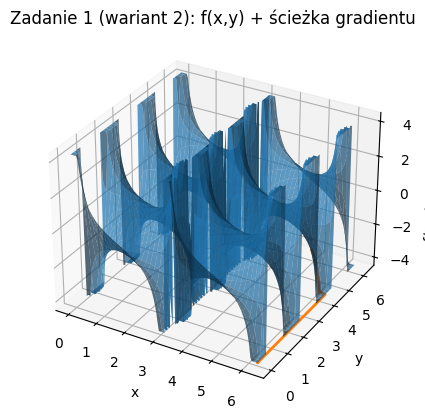

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa


TWO_PI = 2*np.pi
EPS = 1e-3

def f_xy(x, y):
    denom = np.sin(x)
    return np.cos(x + 3*y) / denom

def grad_f_xy(x, y):
    u = x + 3*y
    sinx = np.sin(x)
    cosx = np.cos(x)

    dfdx = (-np.sin(u)/sinx) - (np.cos(u)*cosx/(sinx**2))

    dfdy = -3*np.sin(u)/sinx
    return np.array([dfdx, dfdy])

def project_domain(x, y):
    x = np.clip(x, 0+EPS, TWO_PI-EPS)
    y = np.clip(y, 0, TWO_PI)
    if abs(x - np.pi) < EPS:
        x = np.pi + np.sign(x - np.pi + 1e-12)*EPS
    return x, y

def gradient_descent(x0, y0, lr=0.01, iters=3000, tol=1e-8):
    x, y = project_domain(float(x0), float(y0))
    hist = [(x, y, f_xy(x,y))]

    for i in range(iters):
        g = grad_f_xy(x, y)
        gn = np.linalg.norm(g)

        if not np.isfinite(gn) or not np.isfinite(hist[-1][2]):
            # jak wpadnie w NaN/inf, zrób mały restart w środku dziedziny
            x, y = project_domain(np.random.uniform(EPS, TWO_PI-EPS),
                                 np.random.uniform(0, TWO_PI))
            hist.append((x, y, f_xy(x,y)))
            continue

        if gn < tol:
            break

        x_new = x - lr*g[0]
        y_new = y - lr*g[1]
        x_new, y_new = project_domain(x_new, y_new)
        f_old = hist[-1][2]
        f_new = f_xy(x_new, y_new)

        if not np.isfinite(f_new) or f_new > f_old:
            lr *= 0.5
            continue

        x, y = x_new, y_new
        hist.append((x, y, f_new))

    return x, y, hist

x0 = np.random.uniform(EPS, TWO_PI-EPS)
y0 = np.random.uniform(0, TWO_PI)

xmin, ymin, hist = gradient_descent(x0, y0, lr=0.02, iters=8000, tol=1e-7)

print("Start:", (x0, y0))
print("Minimum (x,y):", (xmin, ymin))
print("f(x,y):", f_xy(xmin, ymin))
print("Iteracje:", len(hist))

xs = np.linspace(EPS, TWO_PI-EPS, 160)
ys = np.linspace(0, TWO_PI, 160)
Xg, Yg = np.meshgrid(xs, ys)
Zg = f_xy(Xg, Yg)

Zg_clip = np.clip(Zg, np.percentile(Zg, 5), np.percentile(Zg, 95))

hx = np.array([h[0] for h in hist])
hy = np.array([h[1] for h in hist])
hz = np.array([h[2] for h in hist])

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(Xg, Yg, Zg_clip, alpha=0.7)
ax.plot(hx, hy, np.clip(hz, Zg_clip.min(), Zg_clip.max()), linewidth=2)
ax.set_title("Zadanie 1 (wariant 2): f(x,y) + ścieżka gradientu")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("f(x,y) (przycięte)")
plt.show()


In [2]:
import numpy as np

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def sigmoid_backward(dA, Z):
    A = sigmoid(Z)
    return dA * A * (1 - A)

def relu(z):
    return np.maximum(0, z)

def relu_backward(dA, Z):
    dZ = dA.copy()
    dZ[Z <= 0] = 0
    return dZ

def init_params(seed=0):
    rng = np.random.default_rng(seed)
    W1 = rng.normal(0, 0.5, (2, 2))
    b1 = np.zeros((2, 1))
    W2 = rng.normal(0, 0.5, (1, 2))
    b2 = np.zeros((1, 1))
    return {"W1": W1, "b1": b1, "W2": W2, "b2": b2}

def forward(X, params):
    W1, b1 = params["W1"], params["b1"]
    W2, b2 = params["W2"], params["b2"]

    Z1 = W1 @ X + b1
    A1 = sigmoid(Z1)

    Z2 = W2 @ A1 + b2
    A2 = relu(Z2)

    cache = {"X": X, "Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}
    return A2, cache

def mse_loss(A2, Y):
    m = Y.shape[1]
    return np.sum((A2 - Y) ** 2) / m

def backward(Y, params, cache):
    W2 = params["W2"]

    X, Z1, A1, Z2, A2 = cache["X"], cache["Z1"], cache["A1"], cache["Z2"], cache["A2"]
    m = X.shape[1]

    dA2 = 2 * (A2 - Y) / m
    dZ2 = relu_backward(dA2, Z2)

    dW2 = dZ2 @ A1.T
    db2 = np.sum(dZ2, axis=1, keepdims=True)

    dA1 = W2.T @ dZ2
    dZ1 = sigmoid_backward(dA1, Z1)

    dW1 = dZ1 @ X.T
    db1 = np.sum(dZ1, axis=1, keepdims=True)

    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
    return grads

params = init_params(seed=42)
X = np.array([[0, 0, 1, 1],
              [0, 1, 0, 1]], dtype=float)
Y = np.array([[0, 1, 1, 0]], dtype=float)  # przykładowo XOR-ish (dla testu)

A2, cache = forward(X, params)
loss = mse_loss(A2, Y)
grads = backward(Y, params, cache)

print("A2:", A2)
print("loss:", loss)
for k,v in grads.items():
    print(k, v.shape, " | norm:", np.linalg.norm(v))


A2: [[0. 0. 0. 0.]]
loss: 0.5
dW1 (2, 2)  | norm: 0.0
db1 (2, 1)  | norm: 0.0
dW2 (1, 2)  | norm: 0.0
db2 (1, 1)  | norm: 0.0


In [3]:
def numerical_grad_check(X, Y, params, key, idx, eps=1e-6):
    p1 = {k: v.copy() for k,v in params.items()}
    p2 = {k: v.copy() for k,v in params.items()}

    p1[key][idx] += eps
    p2[key][idx] -= eps

    A2p, _ = forward(X, p1)
    A2m, _ = forward(X, p2)
    return (mse_loss(A2p, Y) - mse_loss(A2m, Y)) / (2*eps)

A2, cache = forward(X, params)
grads = backward(Y, params, cache)

# sprawdź jeden element
num = numerical_grad_check(X, Y, params, "W1", (0,0))
ana = grads["dW1"][0,0]
print("num:", num, "ana:", ana, "abs diff:", abs(num-ana))


num: 0.0 ana: 0.0 abs diff: 0.0
